Install prereqs

In [132]:
from transformers import BertTokenizer
import pandas as pd
import numpy as np
import itertools
import nltk
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [63]:
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\14803\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [64]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

news = pd.read_csv("bert_news.csv").dropna()

pred_sentences = news['text'].tolist()
map(str,pred_sentences)

tokens = []
failures = []
for p in pred_sentences:
    tokens.append(tokenizer(p, padding=True)['input_ids'])

news_padded = pd.DataFrame(list(zip(*itertools.zip_longest(*tokens, fillvalue=0))))
pd.concat([news,news_padded], axis=1).to_csv("news_vectors.csv",index=False, sep=",",header=True)


In [65]:
from transformers import BertTokenizer
import pandas as pd
import itertools

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

tweets = pd.read_csv("bert_tweets.csv").dropna()

pred_sentences = tweets['text'].tolist()
map(str,pred_sentences)

tokens = []
failures = []
for p in pred_sentences:
    tokens.append(tokenizer(p, padding=True)['input_ids'])

tweets_padded = pd.DataFrame(list(zip(*itertools.zip_longest(*tokens, fillvalue=0))))
pd.concat([tweets,tweets_padded], axis=1).to_csv("tweet_vectors.csv",index=False, sep=",",header=True)


In [66]:
news_padded[153] = 0

In [129]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

sent = []
for text in news['text']:
    s = sid.polarity_scores(text)
    sent.append(s['compound'])

print(len(sent))
news_padded['sentiment'] = sent
news_padded['label'] = news['label']
news['sentiment'] = sent

sent = []
for text in tweets['text']:
    s = sid.polarity_scores(text)
    sent.append(s['compound'])

tweets_padded['sentiment'] = sent
tweets_padded['label'] = tweets['label']
tweets['sentiment'] = tweets

84552


ValueError: Columns must be same length as key

In [90]:
news_padded

,0,1,2,3,4,5,6,7,8,9,...,146,147,148,149,150,151,152,153,sentiment,label
0,101,2054,3736,9397,6537,3793,19390,2000,2274,15991,...,0,0,0,0,0,0,0,0,0.0000,1.0
1,101,7262,1024,26060,4324,6046,4425,7566,2007,2859,...,0,0,0,0,0,0,0,0,0.1280,1.0
2,101,6207,2003,3173,1037,3795,18059,5855,5049,1010,...,0,0,0,0,0,0,0,0,0.5106,1.0
3,101,1996,4013,2015,1998,9530,2015,1997,9343,6207,...,0,0,0,0,0,0,0,0,0.0000,1.0
4,101,7570,20049,2121,3316,2426,1005,2087,12749,1005,...,0,0,0,0,0,0,0,0,0.5563,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84547,101,2076,1996,2197,2261,2420,1997,2355,1010,1996,...,0,0,0,0,0,0,0,0,0.0000,0.0
84548,101,6967,9466,1010,2978,3597,2378,4212,1010,5199,...,0,0,0,0,0,0,0,0,-0.1027,0.0
84549,101,4518,3006,2651,1024,15768,3816,2004,11738,5083,...,0,0,0,0,0,0,0,0,0.0000,0.0
84550,101,2076,1996,2197,2261,2420,1997,2355,1010,1996,...,0,0,0,0,0,0,0,0,0.0000,0.0


In [93]:
tweetsX = tweets_padded.dropna().drop(columns=['label'])
tweetsY = tweets_padded.dropna()['label']

newsX = news_padded.dropna().drop(columns=['label'])
newsY = news_padded.dropna()['label']


In [96]:
frames = [tweetsX,newsX]
combinedX = pd.concat(frames).reset_index(drop=True)
frames = [tweetsY,newsY]
combinedY = pd.concat(frames).reset_index(drop=True)

In [97]:
print(len(combinedX))
print(len(combinedY))

169104
169104


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(tweetsX.to_numpy(), tweetsY.to_numpy(), test_size=0.2, random_state=27)
clftweets = LogisticRegression(class_weight='balanced')
clftweets.fit(X_train,Y_train)

In [ ]:
pred_prob = clftweets.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(Y_test, pred_prob)
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr, tpr, label = 'Logistic Regression with BERT Encodings')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
auc = 'AUC: ' + str(roc_auc_score(Y_test, pred_prob))
plt.legend([auc[:9]])
plt.savefig('method2_tweets_roc.png', bbox_inches='tight')
plt.show()

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(newsX.to_numpy(), newsY.to_numpy(), test_size=0.2, random_state=27)
clfnews = LogisticRegression()
clfnews.fit(X_train,Y_train)

In [ ]:
pred_prob = clfnews.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(Y_test, pred_prob)
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr, tpr, label = 'Logistic Regression with BERT Encodings')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
auc = 'AUC: ' + str(roc_auc_score(Y_test, pred_prob))
plt.legend([auc[:9]])
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.savefig('method2_news_roc.png',bbox_inches='tight')
plt.show()

In [142]:
X_train, X_test, Y_train, Y_test = train_test_split(combinedX.to_numpy(), combinedY.to_numpy(), test_size=0.2, random_state=27)
clfnews = LogisticRegression()
clfnews.fit(X_train,Y_train)

clf = LogisticRegression()
clf.fit(X_train,Y_train)

C:\Users\14803\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\14803\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

LogisticRegression()

In [131]:
predictions = clf.predict(X_test)
accuracy = clf.score(X_test, Y_test)
f1 = f1_score(predictions, Y_test, average='binary')
precision = precision_score(predictions, Y_test)
recall = recall_score(predictions, Y_test)

print('Accuracy:', accuracy)
print('Precision:',precision)
print('Recall:', recall)
print('F1 Score:',f1)

Accuracy: 0.5060761065610124
Precision: 0.5089324857518632
Recall: 0.5452997475192296
F1 Score: 0.5264888460557272


In [ ]:
import pickle
pickle.dump(clf,open('bert_logreg.sav','wb'))

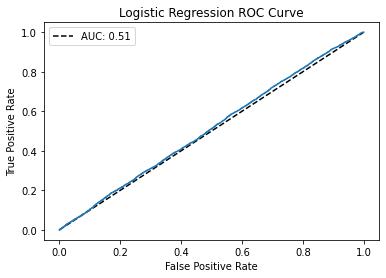

In [119]:
pred_prob = clf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(Y_test, pred_prob)
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr, tpr, label = 'Logistic Regression with BERT Encodings')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
auc = 'AUC: ' + str(roc_auc_score(Y_test, pred_prob))
plt.legend([auc[:9]])
plt.show()